# Building the Network

Here I'm going to use the list of interactions built as shown in the first notebook to build a full graph of the network and take some basic centrality measures. I'll then make a smaller graph, repeat the measures and export a graphml file that can be used in Gephi.  
First I import the nessecary libraries and some functions I wrote.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


The below functions do the following:  
* __build_dataFrame__: Takes a pandas dataframe and filters it on date. Isn't used much at the moment but can be expanded later to filter on location.  
* __get_graph_stats__: Takes a graph and returns a dataframe with a number of different centrality measures calculated.  
* __build_graph__: Takes a dataframe and builds a graph from it. Adds nodes and edges to the graph if they are not present. If an edge is already present it increases its weight by 1.  
* __filter_built_graph__: Takes a graph and a weight and returns a smaller graph where all edges smaller than the weight have been removed.  
* __rebuild_dataFrame_from_stats__: I didn't use this one much. It takes a dataframe returned from the get_graph_stats function above, a column name and a value. It returns a dataframe containing nodes who have a value for that column greater than the value given to the function. The default is to return all nodes with an Eigenvector value above 0.01.    

In [2]:
# Take in parameters from user (date range), return dataframe
def build_dataFrame(df, startDate = '1915-05-31', endDate = '1916-04-19'):
    out_df = df[(df['Date'] >= startDate) & (df['Date'] <= endDate)]
    out_df = out_df.drop('Date', 1).reset_index(drop = True)
    return out_df 

# Return stats of graph (degree, centrality etc)
def get_graph_stats(graph, by_col = ''):   
    degree = pd.DataFrame.from_dict(graph.degree(graph), orient = 'index').reset_index()
    degree.rename(columns={'index': 'Name', 0: 'Degree'}, inplace=True)
    
    degree_cent = pd.DataFrame.from_dict(nx.degree_centrality(graph), orient = 'index').reset_index()
    degree_cent.rename(columns={'index': 'Name', 0: 'Deg Cent'}, inplace=True)
    
    stats_df = pd.merge(degree, degree_cent, on = ['Name', 'Name'])
    
    close_cent = pd.DataFrame.from_dict(nx.closeness_centrality(graph), orient = 'index').reset_index()
    close_cent.rename(columns={'index': 'Name', 0: 'Close Cent'}, inplace=True)
    
    stats_df = pd.merge(stats_df, close_cent, on = ['Name', 'Name'])
    
    betw_cent = pd.DataFrame.from_dict(nx.betweenness_centrality(graph), orient = 'index').reset_index()
    betw_cent.rename(columns={'index': 'Name', 0: 'Betw Cent'}, inplace=True)
    
    stats_df = pd.merge(stats_df, betw_cent, on = ['Name', 'Name'])
    
    eigenvector = pd.DataFrame.from_dict(nx.eigenvector_centrality(graph), orient = 'index').reset_index()
    eigenvector.rename(columns={'index': 'Name', 0: 'Eigenvector'}, inplace=True)
    
    stats_df = pd.merge(stats_df, eigenvector, on = ['Name', 'Name'])
    
    pagerank = pd.DataFrame.from_dict(nx.pagerank(graph), orient = 'index').reset_index()
    pagerank.rename(columns={'index': 'Name', 0: 'PageRank'}, inplace=True)
    
    stats_df = pd.merge(stats_df, pagerank, on = ['Name', 'Name'])
    
    if by_col != '':
        stats_df = stats_df.sort_values(by = by_col, ascending = False).reset_index(drop = True)
    
    return stats_df

# build the graph that will be used for
def build_graph(df):
    G = nx.Graph()

    for i in range(0, len(df)):
        if not G.has_node(df.iloc[i, 0]):
            G.add_node(df.iloc[i, 0])
        if not G.has_node(df.iloc[i, 1]):
            G.add_node(df.iloc[i, 1])

        if not G.has_edge(df.iloc[i, 0], df.iloc[i, 1]):
            G.add_edge(df.iloc[i, 0], df.iloc[i, 1])
            G[df.iloc[i, 0]][df.iloc[i, 1]]['weight'] = 1
        else:
            G[df.iloc[i, 0]][df.iloc[i, 1]]['weight'] += 1
    
    return G

#Filter a previous built graph, remove edges below a certain weight (returns a new graph)
def filter_built_graph(graph, weight):
    out_graph = nx.Graph()
    for source, target, data in graph.edges(data = True):
        if data['weight'] >= weight:
            out_graph.add_edge(source, target, data)
    
    return out_graph    

# After building graph rebuild dataFrame using PageRank, closeness etc
def rebuild_dataFrame_from_stats(stats_in, df_in, by_column = 'Eigenvector', value = 0.01):
    stats_in = stats_in[stats_in[by_column] >= value].sort_values(by = by_column, ascending = False)
    
    names = list(stats_in['Name'])
    
    df_out = df_in[(df_in['Source'].isin(names)) & (df_in['Target'].isin(names))]
    
    return df_out.reset_index(drop = True)

In [3]:
# encoding='cp1252' is used to read in names that contain a fada, like Seán.
ex_df = pd.read_csv('../1916_edge_list.csv', encoding='cp1252')
ex_df.columns = ['Date', 'Source', 'Target']
ex_df['Date'] = pd.to_datetime(ex_df['Date'], dayfirst = True, format = '%d %B %Y')

In [4]:
ex_df.head()

,Date,Source,Target
0,1915-05-31,Eoin MacNeill,Tom Clarke
1,1915-05-31,Thomas Byrne,Tom Clarke
2,1915-05-31,Frank Fahy,Tom Clarke
3,1915-05-31,George Irvine,Tom Clarke
4,1915-05-31,Seán T. O'Kelly,Tom Clarke


# Full Network

Using the functions I wrote above I can now build a graph of the full network. This graph will have 233 nodes and 3995 edges and it will take a while for the stats to return as some, like Eigenvector and Betweenness, are run on the whole network multiple times. 

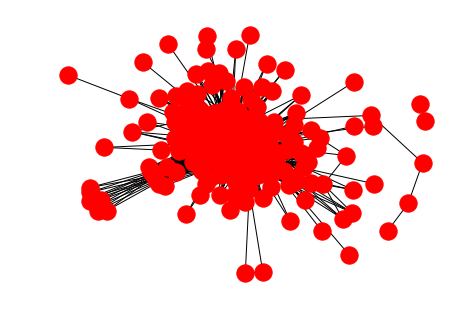

In [6]:
# Build dataframe to be used by applying date filters
full_df = build_dataFrame(ex_df)

# convert dataframe to graph
ex_graph_full = build_graph(full_df)

# get stats from graph
stats = get_graph_stats(ex_graph_full)

#draw graph
nx.draw(ex_graph_full)

#savefig("graphImages/1916-full-graph.png")

#nx.write_graphml(ex_graph_full, '1916-full-graph.graphml')

The full graph can be described as a "Hairball Graph". It's difficult to pickout any pattern because there are so many weak ties between people that everyone clumps together. Even in Gephi there are so many links that at this level there is little structure.  
The handle coming out of the graph to the right is a number of women who speak at suffragette meetings and the cluster in the bottom left is a meeting of the Ancient Order of Hibernians. Instead of going down through all the centrality measures for this graph I will print off the head of the stats dataframe ordered by PageRank.

In [7]:
stats.sort_values(by='PageRank', ascending = False).head(15)

,Name,Degree,Deg Cent,Close Cent,Betw Cent,Eigenvector,PageRank
194,Tom Clarke,130,0.560345,0.657110,0.105605,0.317174,0.051385
3,The O'Rahilly,125,0.538793,0.653345,0.031094,0.292104,0.029435
74,Bulmer Hobson,121,0.521552,0.653345,0.034218,0.276175,0.026817
148,Michael O'Hanrahan,104,0.448276,0.621300,0.025235,0.256247,0.024084
188,Seán MacDiarmada,114,0.491379,0.636920,0.025458,0.221117,0.023021
27,Thomas MacDonagh,117,0.504310,0.636920,0.024133,0.225071,0.022652
36,Herbert Mellows,97,0.418103,0.604820,0.021001,0.246146,0.021695
217,Éamonn Ceannt,119,0.512931,0.651478,0.034505,0.184655,0.020769
51,Piaras Béaslaí,125,0.538793,0.655222,0.037174,0.161031,0.018777
64,Seán T. O'Kelly,127,0.547414,0.660920,0.034973,0.145478,0.018662


Tom Clarke is the most popular node in the graph and also has a high Eigenvector centrality. A number of nodes have Degree centralities placing them in contact with over 50% of the network but most of these are very weak ties. It is interesting to see that Clarke has a low Betweenness score; while he is an important node he doesn't appear on many of the shortest paths.

# Edge Weight Over 25

The majority of the edges in the network have a weight of 1, meaning the nodes they connect were only seen together once. I'm going to filter out all edges that have a weight less than 25 and rebuild the network.

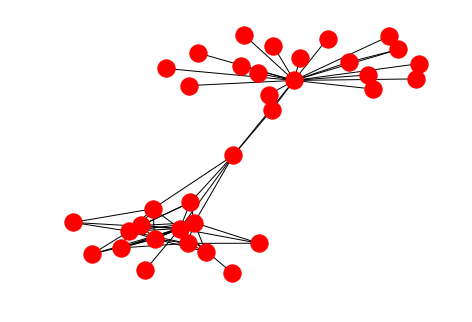

In [8]:
# filter the full graph, include only edges greather than or equal to 25
ex_graph_25 = filter_built_graph(ex_graph_full, 25)

stats_25 = get_graph_stats(ex_graph_25)

nx.draw(ex_graph_25)

In [9]:
print(len(ex_graph_25.nodes()))
print(len(ex_graph_25.edges()))

35
67


There is now a much smaller graph containing 35 nodes and 67 edges connecting them. At the top is a star cluster surrounding Tom Clarke. At the bottom is a more heavily linked cluster including members of the Irish Volunteers. The node in the centre with four edges coming off of it into the Irish Volunteers cluster is Seán MacDiarmada. Removing this node would split the graph in two.

## Cliques

A clique is a subgraph where all the nodes present are connected to each other. Extending the subgraph by one node and not connecting it to all the others means that is it no longer a clique. We can find the cliques in the graph above, filtering out all that contain only two nodes. Names with a fada over one of the letters don't render correctly below.

In [10]:
for clique in nx.find_cliques(ex_graph_25):
    if len(clique) > 2:
        print(clique)

[u'Patrick Ryan', u'Herbert Mellows', u"The O'Rahilly", u'Bulmer Hobson']
[u'Herbert Mellows', u"Michael O'Hanrahan", u"The O'Rahilly", u'Bulmer Hobson', u'Thomas MacDonagh', u"J.J. O'Connell"]
[u'Herbert Mellows', u"Michael O'Hanrahan", u"The O'Rahilly", u'Bulmer Hobson', u"Eimar O'Duffy"]
[u'\xc9amon De Valera', u'Thomas MacDonagh', u"The O'Rahilly", u"Michael O'Hanrahan"]
[u"Michael O'Hanrahan", u"The O'Rahilly", u'\xc9amonn Ceannt', u'Thomas MacDonagh', u'John Fitzgibbon']
[u"Michael O'Hanrahan", u"The O'Rahilly", u'John Fitzgibbon', u'Bulmer Hobson', u'Thomas MacDonagh']
[u'P.H. Pearse', u'Thomas MacDonagh', u'\xc9amonn Ceannt', u"The O'Rahilly"]
[u"The O'Rahilly", u"J. O'Connor", u'Bulmer Hobson', u'Thomas MacDonagh', u'John Fitzgibbon']
[u"The O'Rahilly", u"J. O'Connor", u'Bulmer Hobson', u'Se\xe1n MacDiarmada']
[u"The O'Rahilly", u'Se\xe1n MacDiarmada', u'\xc9amonn Ceannt']
[u'Tom Clarke', u'Se\xe1n MacDiarmada', u'Se\xe1n McGarry']
[u'Tom Clarke', u"William O'Leary Curtis", u'

Tom Clarke appears in only two cliques while The O'Rahilly appears in all the others, many of them with Bulmer Hobson. Lets see how the stats have changed on this smaller network.

In [11]:
stats_25.sort_values(by='PageRank', ascending = False).head(15)

,Name,Degree,Deg Cent,Close Cent,Betw Cent,Eigenvector,PageRank
14,Tom Clarke,19,0.558824,0.566667,0.755793,0.116530,0.234392
3,The O'Rahilly,15,0.441176,0.485714,0.299822,0.454276,0.081192
24,Bulmer Hobson,10,0.294118,0.453333,0.110071,0.430476,0.057982
23,Michael O'Hanrahan,9,0.264706,0.357895,0.008675,0.381324,0.048461
25,Thomas MacDonagh,10,0.294118,0.361702,0.014023,0.292554,0.044139
20,Herbert Mellows,7,0.205882,0.350515,0.003268,0.376071,0.043452
12,Seán MacDiarmada,6,0.176471,0.548387,0.508824,0.140997,0.035348
26,William O'Leary Curtis,2,0.058824,0.369565,0.000000,0.042349,0.031863
28,Éamonn Ceannt,6,0.176471,0.430380,0.048723,0.148471,0.025289
4,John Fitzgibbon,6,0.176471,0.346939,0.001248,0.178787,0.024604


There are now a number of people who are only connected to less than 20% of the network. Both Clarke and MacDiarmada have high Betweenness scores as they are very important for connecting the two groups. Clarke appears to be the only person with a PageRank greater than 0.1 but has a lower Eigenvector score than The O'Rahilly or Bulmer Hobson. Closesness has also dropped for many of the nodes as there are now a number of steps for them to reach other nodes.

# Edge Weight Over 25 - Reconnected

While I filtered out the edges less than 25 to remove weaker ties these can often have an important role to play in how information travels in a nework. The 35 nodes above all have at least one edge of 25 or greater. I will build a subgraph of the big hairball graph that only includes these nodes, meaning that all edges between them will be present. Here we are looking at all the ways the most strongly connected nodes are connected.

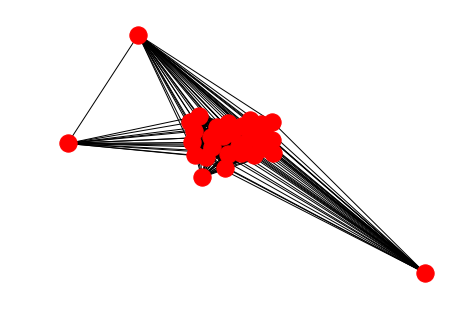

In [16]:
# Make a subgraph of the full network including only those nodes from the ex_graph_25 network
ex_25_recon = ex_graph_full.subgraph(ex_graph_25.nodes())

# The 1 can be changed to get a graph with stronger connections. Setting it to 10 will return all connectiosn between 10 and 25
ex_25_recon_graph = filter_built_graph(ex_25_recon, 1)

ex_25_recon_stats = get_graph_stats(ex_25_recon_graph)

nx.draw(ex_25_recon_graph)

In [17]:
print(len(ex_25_recon_graph.nodes()))
print(len(ex_25_recon_graph.edges()))

35
518


There are the same number of nodes as before but they are now joined by almost 8 times as many edges. Networkx does have tools for changing the layout of a graph, getting the nodes to seperate and form groups. I planned doing all the final graphing in Gephi so I didn't worry about this too much. [The above graph in Gephi is on my blog.](http://www.anquantarbuile.com/social-network-of-the-1916-rising) This is using the force atlas 2 layout. The thickness of the edges represents the weight of the edge. The nodes are sized by PageRank and the colors are from Gephi modularity statistic which looks to find seperate communities in the network. Just like our previous graph it has pulled out a Tom Clarke community and an Irish Volunteer community.

In [18]:
ex_25_recon_stats.sort_values(by='PageRank', ascending = False).head(15)

,Name,Degree,Deg Cent,Close Cent,Betw Cent,Eigenvector,PageRank
14,Tom Clarke,33,0.970588,0.971429,0.006353,0.331973,0.091329
3,The O'Rahilly,31,0.911765,0.918919,0.003608,0.302895,0.050751
24,Bulmer Hobson,31,0.911765,0.918919,0.003371,0.288280,0.047437
23,Michael O'Hanrahan,31,0.911765,0.918919,0.003729,0.266199,0.042418
12,Seán MacDiarmada,34,1.000000,1.000000,0.007748,0.230578,0.041385
28,Herbert Mellows,32,0.941176,0.944444,0.004198,0.258344,0.041072
25,Thomas MacDonagh,33,0.970588,0.971429,0.006562,0.231822,0.040547
20,Éamonn Ceannt,33,0.970588,0.971429,0.005266,0.186987,0.034287
16,J. O'Connor,31,0.911765,0.918919,0.003729,0.186357,0.032716
32,Con Colbert,33,0.970588,0.971429,0.005266,0.179327,0.031489


Now with all these weak connections factored in Degree and Closeness centrality have gone way up. Everyones Betweenness centrality has dropped as there are now multiple different paths from one node to another. Eigenvector scores have moved in line with PageRank, sharing a similar ranking. However we see many of the same names appearing across the measures and across the graphs. 

Uncommenting and running the following line, if you have run all the previous lines, will write out this graph to a graphml file which can be imported into Gephi.

In [19]:
#nx.write_graphml(ex_25_recon_graph, '1916-w25-reconnected.graphml')

## Conclusions

A large amount of documentation was created during and about the period 1916-1923 and as we push through the centenary of many of the most important events in the founding of the Irish Nation these documents are being released to the public at large. The military archives are releasing massive volumes of data covering pension applications by those who fought in the 1916 Rising and the War of Independence, medal applications, rollbooks for the IRA, Cumman na mBan and others. Data science has an important role to play in both analysing these documents and providing new ways of looking at them.